# Two examples to illustrate the root cause discovery method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import itertools
np.set_printoptions(suppress=True, precision=10)

from funcs.simulation_setting_funcs import *
from funcs.root_cause_discovery_funcs import *

## 1. Example 1 in the paper

In [2]:
def root_cause_discovery_allperm(X_obs, X_int):
    p = X_obs.shape[1]
    assert p == len(X_int), "Number of variables mismatch"
    
    z = zscore(X_obs, X_int)
    root_cause_score = np.zeros(p)
    permutations = list(itertools.permutations(range(p)))
    # try all permutations to calculate 'Xtilde'
    for perm in permutations:
        Xtilde = root_cause_discovery(X_obs, X_int, perm)
        sorted_X = sorted(Xtilde)
        OneNonZero_quantification = (sorted_X[-1] - sorted_X[-2]) / sorted_X[-2]
        max_index = np.argmax(Xtilde)
        if root_cause_score[max_index] < OneNonZero_quantification:
            root_cause_score[max_index] = OneNonZero_quantification

    # assign final root cause score for variables that never had maximal Xtilde_i
    idx2 = np.where(root_cause_score == 0)[0]
    if len(idx2) != 0:
        idx1 = np.where(root_cause_score != 0)[0]
        max_RC_score_idx2 = np.min(root_cause_score[idx1])/2
        root_cause_score[idx2] = z[idx2] / (np.max(z[idx2]) / max_RC_score_idx2)
    return root_cause_score
    
# Simulations for Example 1 in the paper
def Simu_example1(int_r):
    p = 3
    n = 100
    m = 60
    b1 = 1
    b2 = 1
    b3 = 1
    
    sigma_C = 1
    sigma_j = 1
    sigma_k = 1
    alpha = -1
    beta = 2
    gamma = 1
    
    # check the success condition:  > 0 holds
    # check = sigma_k**2 + gamma**2 * sigma_C**2  + 2*alpha*beta*gamma*sigma_C**2
    # print(check<0)
    
    # observational sample
    C = np.full(n, b1) + np.random.normal(0, 1, n)
    Xj = np.full(n, b2) + beta*C + np.random.normal(0, 1, n)
    Xk = np.full(n, b3) + alpha*Xj + gamma*C + np.random.normal(0, 1, n)
    obs_data = np.column_stack((C,Xj,Xk))
    
    # random intervention for each sample: we set the strength of intervention large
    # for checking the theoretical results.
    delta_C = np.zeros(m)
    delta_j = np.zeros(m)
    delta_k = np.zeros(m)
    # Inter_target = np.random.choice([1,2,3], m)
    Inter_target = np.concatenate((np.full(m//3, 1), np.full(m//3, 2), np.full(m//3, 3)))
    
    delta_C[Inter_target==1] = np.full(np.sum(Inter_target==1), int_r)
    delta_j[Inter_target==2] = np.full(np.sum(Inter_target==2), int_r)
    delta_k[Inter_target==3] = np.full(np.sum(Inter_target==3), int_r)
    # interventional sample
    C_I = np.full(m, b1) + np.random.normal(0, 1, m) + delta_C
    Xj_I = np.full(m, b2) + beta*C_I + np.random.normal(0, 1, m) + delta_j 
    Xk_I = np.full(m, b3) + alpha*Xj_I + gamma*C_I + np.random.normal(0,1, m) + delta_k
    intv_data = np.column_stack((C_I,Xj_I,Xk_I))
    
    Zscore_mat = zscore(obs_data, intv_data)
    
    Cholscore_mat = np.zeros(intv_data.shape)
    for sample_idx in range(intv_data.shape[0]):
        intv_one_sample = intv_data[sample_idx,:]
        Cholscore_mat[sample_idx,:] = root_cause_discovery_allperm(obs_data, intv_one_sample)
    
    return Zscore_mat, Cholscore_mat

def example1_plt(ax, data, ylabel, xlabel, title, color_dict, legend=False):
    for i in range(data.shape[1]):
        RC_idx = np.full(data.shape[0], 0)
        RC_idx[20*i:20*(i+1)] = 1
        ax.scatter(
            np.arange(data.shape[0]), 
            data[:, i], 
            color=[color_dict[idx] for idx in RC_idx],
            alpha=0.7,  # Add some transparency to avoid overlap
            s=50,  # Marker size
            edgecolor='k'  # Add border to markers
        )
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.6)  # Add grid for better readability

    if legend == True:
        # Create a common legend for the figure
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[0], markersize=6, label=labels[0]),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[1], markersize=6, label=labels[1])
        ]
        
        # Add the common legend above the last row of plots
        fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.9))

def get_rank_example1(Zscore_mat, Cholesky_mat, m):
    RC_idx = np.concatenate((np.full(m//3, 0), np.full(m//3, 1), np.full(m//3, 2)))
    
    RC_rank = np.zeros((m,2))
    for i in range(m):
        Zscore_temp = Zscore_mat[i,:]
        Cholscore_temp = Cholesky_mat[i,:]
        RC_rank[i,0] = np.sum(Zscore_temp[RC_idx[i]] < Zscore_temp) + 1
        RC_rank[i,1] = np.sum(Cholscore_temp[RC_idx[i]] < Cholscore_temp) + 1
    return RC_rank

def plot_histogram(ax, data, legend=False, title=None):
    # Compute histogram data
    bins = np.arange(0.5, 4.5, 1)  # Define bin edges
    hist1, _ = np.histogram(data[:, 0], bins=bins)
    hist2, _ = np.histogram(data[:, 1], bins=bins)

    # Plot histograms
    width = 0.4  # Bar width
    x = np.arange(1, 4)  # X locations for the groups
    # ax.bar(x - width/2, hist1, width=width, label='Z-score', color='skyblue', edgecolor='black')
    # ax.bar(x + width/2, hist2, width=width, label='Cholesky-score', color='salmon', edgecolor='black')
    ax.bar(x - width/2, hist1, width=width, label='Z-score', color='darkorange', edgecolor='black')
    ax.bar(x + width/2, hist2, width=width, label='Cholesky-score', color='forestgreen', edgecolor='black')

    # Customize the plot
    ax.set_xticks(x)
    ax.set_xticklabels(['1', '2', '3'])
    ax.set_xlabel('Rank of the root cause')
    ax.set_ylabel('count')
    ax.set_title(title)
    ax.grid(axis='y')
    if legend == True:
        ax.legend()

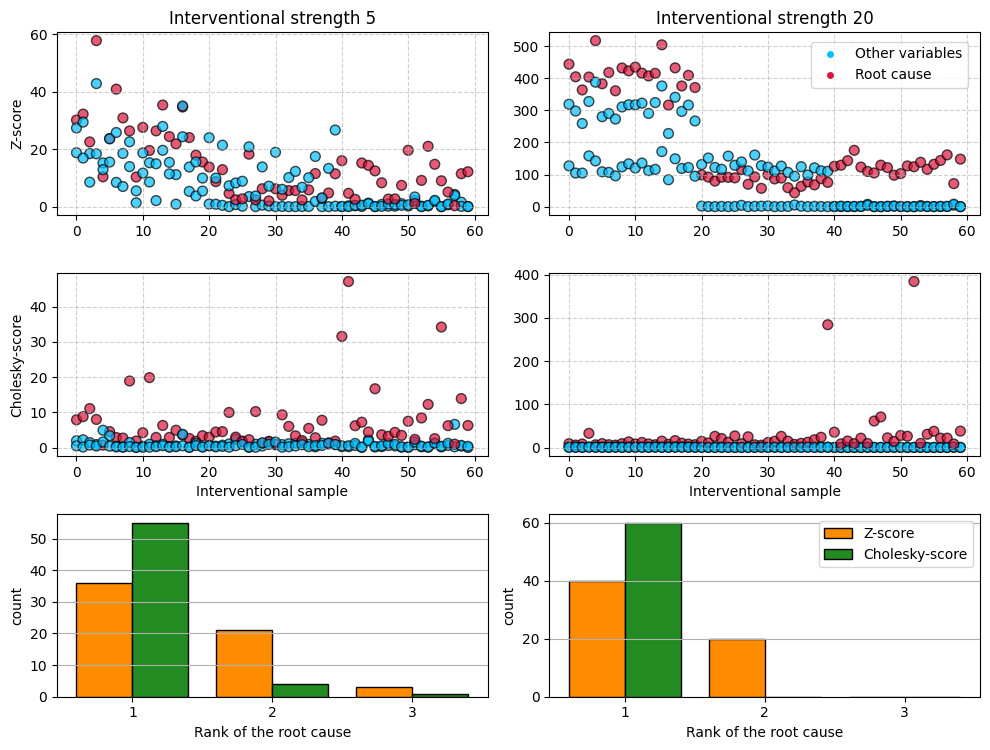

In [3]:
np.random.seed(1234)
m = 60

Zscore_mat1, Cholesky_mat1 = Simu_example1(5)
rank_RC1 = get_rank_example1(Zscore_mat1, Cholesky_mat1, m)

Zscore_mat2, Cholesky_mat2 = Simu_example1(20)
rank_RC2 = get_rank_example1(Zscore_mat2, Cholesky_mat2, m)

# Define colors and labels
color_dict = {0: 'deepskyblue', 1: 'crimson'}
labels = ['Other variables', 'Root cause']

# Create subplots for a 3x2 layout with a more compact design
fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(3, 2, figsize=(10, 8))

# Plot Zscore_mat and Cholesky_mat on the left column (ax1, ax2)
example1_plt(ax1, Zscore_mat1, 'Z-score', '', 'Interventional strength 5', color_dict)
example1_plt(ax2, Cholesky_mat1, 'Cholesky-score', 'Interventional sample', '', color_dict, True)

# Plot histogram in the left column (ax3)
plot_histogram(ax3, rank_RC1)

# Repeat plots on the right column (ax4, ax5)
example1_plt(ax4, Zscore_mat2, '', '', 'Interventional strength 20', color_dict)
example1_plt(ax5, Cholesky_mat2, '', 'Interventional sample', '', color_dict)

# Repeat histogram in the right column (ax6)
plot_histogram(ax6, rank_RC2, True)

# Adjust the layout for a more compact appearance
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust as needed for your paper
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(f"Example1.png", dpi=300, bbox_inches='tight')

# Show the final plot
plt.show()


## Example 2. random DAG

In [4]:
n = 100
s_B = 0.5
dag_type = "random"

p = 10
nshuffles = 10

B_value_min = -1
B_value_max = 1
err_min = 1
err_max = 5
var_X_min = 10
var_X_max = 50

delta_r = 20

In [5]:
np.random.seed(321)
B, sigma2_error, b = generate_setting(dag_type, s_B, B_value_min, B_value_max, err_min, err_max, var_X_min, var_X_max, 
                                      p=p,tol=5, step_size=0.1, max_count=500) 
I = np.identity(p)
X_obs = np.zeros((n, p))
for i in range(n):
    error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
    X_obs[i, :] = linalg.solve(I - B, (b + error).T).reshape(p)

RC = 6 # X7 is intervened
delta = np.repeat(0, p)
delta[RC] = delta_r
error = np.random.multivariate_normal(np.repeat(0, p), sigma2_error, 1)
X_int = linalg.solve(I - B, (b + error + delta).T).reshape(p)

Zscores = zscore(X_obs, X_int)
CholScores = root_cause_discovery_main(X_obs, X_int, nshuffles=nshuffles, verbose=False)

print("Raw Value:")
print(np.round(abs(X_int),2))
print(f"Rank of RC: {sum(abs(X_int) > abs(X_int)[RC])+1}", "\n")

print("Z-score:")
print(np.round(abs(Zscores),2))
print(f"Rank of RC: {sum(abs(Zscores) > abs(Zscores)[RC])+1}", "\n")

print("Cholesky-score:")
print(np.round(abs(CholScores),2))
print(f"Rank of RC: {sum(abs(CholScores) > abs(CholScores)[RC])+1}", "\n")

Raw Value:
[30.19 74.78 27.01 42.2  43.64  0.8  22.77 86.33 43.01  8.05]
Rank of RC: 8 

Z-score:
[ 30.   182.88  43.83  75.23  76.98   0.27  13.62 171.62 145.16   1.27]
Rank of RC: 8 

Cholesky-score:
[0.19 3.53 0.06 1.08 1.11 2.64 7.54 3.47 2.04 0.03]
Rank of RC: 1 

